## sonfication method implementation

In [23]:
import os
import numpy as np
from sklearn.datasets import fetch_openml
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

# Load MNIST data
mnist = fetch_openml('mnist_784', version=1)
images, labels = mnist["data"], mnist["target"]

# Create directories for outputs
os.makedirs("audio_files", exist_ok=True)
os.makedirs("image_files", exist_ok=True)

def extract_features(image):
    """Extract normalized intensity and edge strength from an image."""
    normalized_intensity = image / 255.0
    gradient = np.gradient(normalized_intensity)
    edge_strength = np.sqrt(gradient[0]**2 + gradient[1]**2)
    return normalized_intensity, edge_strength

def map_features_to_sound_params(intensity, edges, max_frequency=4000, max_volume=32767):
    """Map intensity and edges to sound parameters."""
    frequencies = np.interp(edges, [edges.min(), edges.max()], [200, max_frequency])
    volumes = np.interp(intensity, [intensity.min(), intensity.max()], [100, max_volume])
    return frequencies, volumes

def synthesize_sound(image, sample_rate=44100, duration_per_pixel=0.01, max_volume=32767):
    """Synthesize sound from an image based on intensity and edges."""
    pixel_intensity, edges = extract_features(image)
    frequencies, volumes = map_features_to_sound_params(pixel_intensity, edges)
    
    audio = np.zeros(int(sample_rate * duration_per_pixel * image.shape[0] * image.shape[1]))
    t = np.linspace(0, duration_per_pixel, int(sample_rate * duration_per_pixel), False)
    
    index = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            freq = frequencies[i, j]
            vol = volumes[i, j]
            waveform = vol * np.sin(2 * np.pi * freq * t)
            audio[index:index+len(t)] += waveform
            index += len(t)
    
    audio = audio / np.max(np.abs(audio)) * max_volume
    return audio.astype(np.int16)

# Initialize digit count for balanced dataset
digit_count = {str(i): 0 for i in range(10)}
max_per_digit = 1000  # Set the max number of images per digit

# Process images to achieve balanced dataset
for index, (img, label) in enumerate(zip(images.to_numpy(), labels)):
    if digit_count[label] < max_per_digit:
        image = img.reshape(28, 28).astype(int)
        audio = synthesize_sound(image)
        
        # Save audio file
        audio_filename = f"audio_files/mnist_digit_{label}_{index}.wav"
        write(audio_filename, 44100, audio)
        
        # Save image file
        image_filename = f"image_files/mnist_digit_{label}_{index}.png"
        plt.imsave(image_filename, image, cmap='gray')

        # Update count
        digit_count[label] += 1
        
        # Check if all digits have reached the required count
        if all(count == max_per_digit for count in digit_count.values()):
            break

print("Dataset creation complete. Each digit has 1000 examples.")


Dataset creation complete. Each digit has 1000 examples.


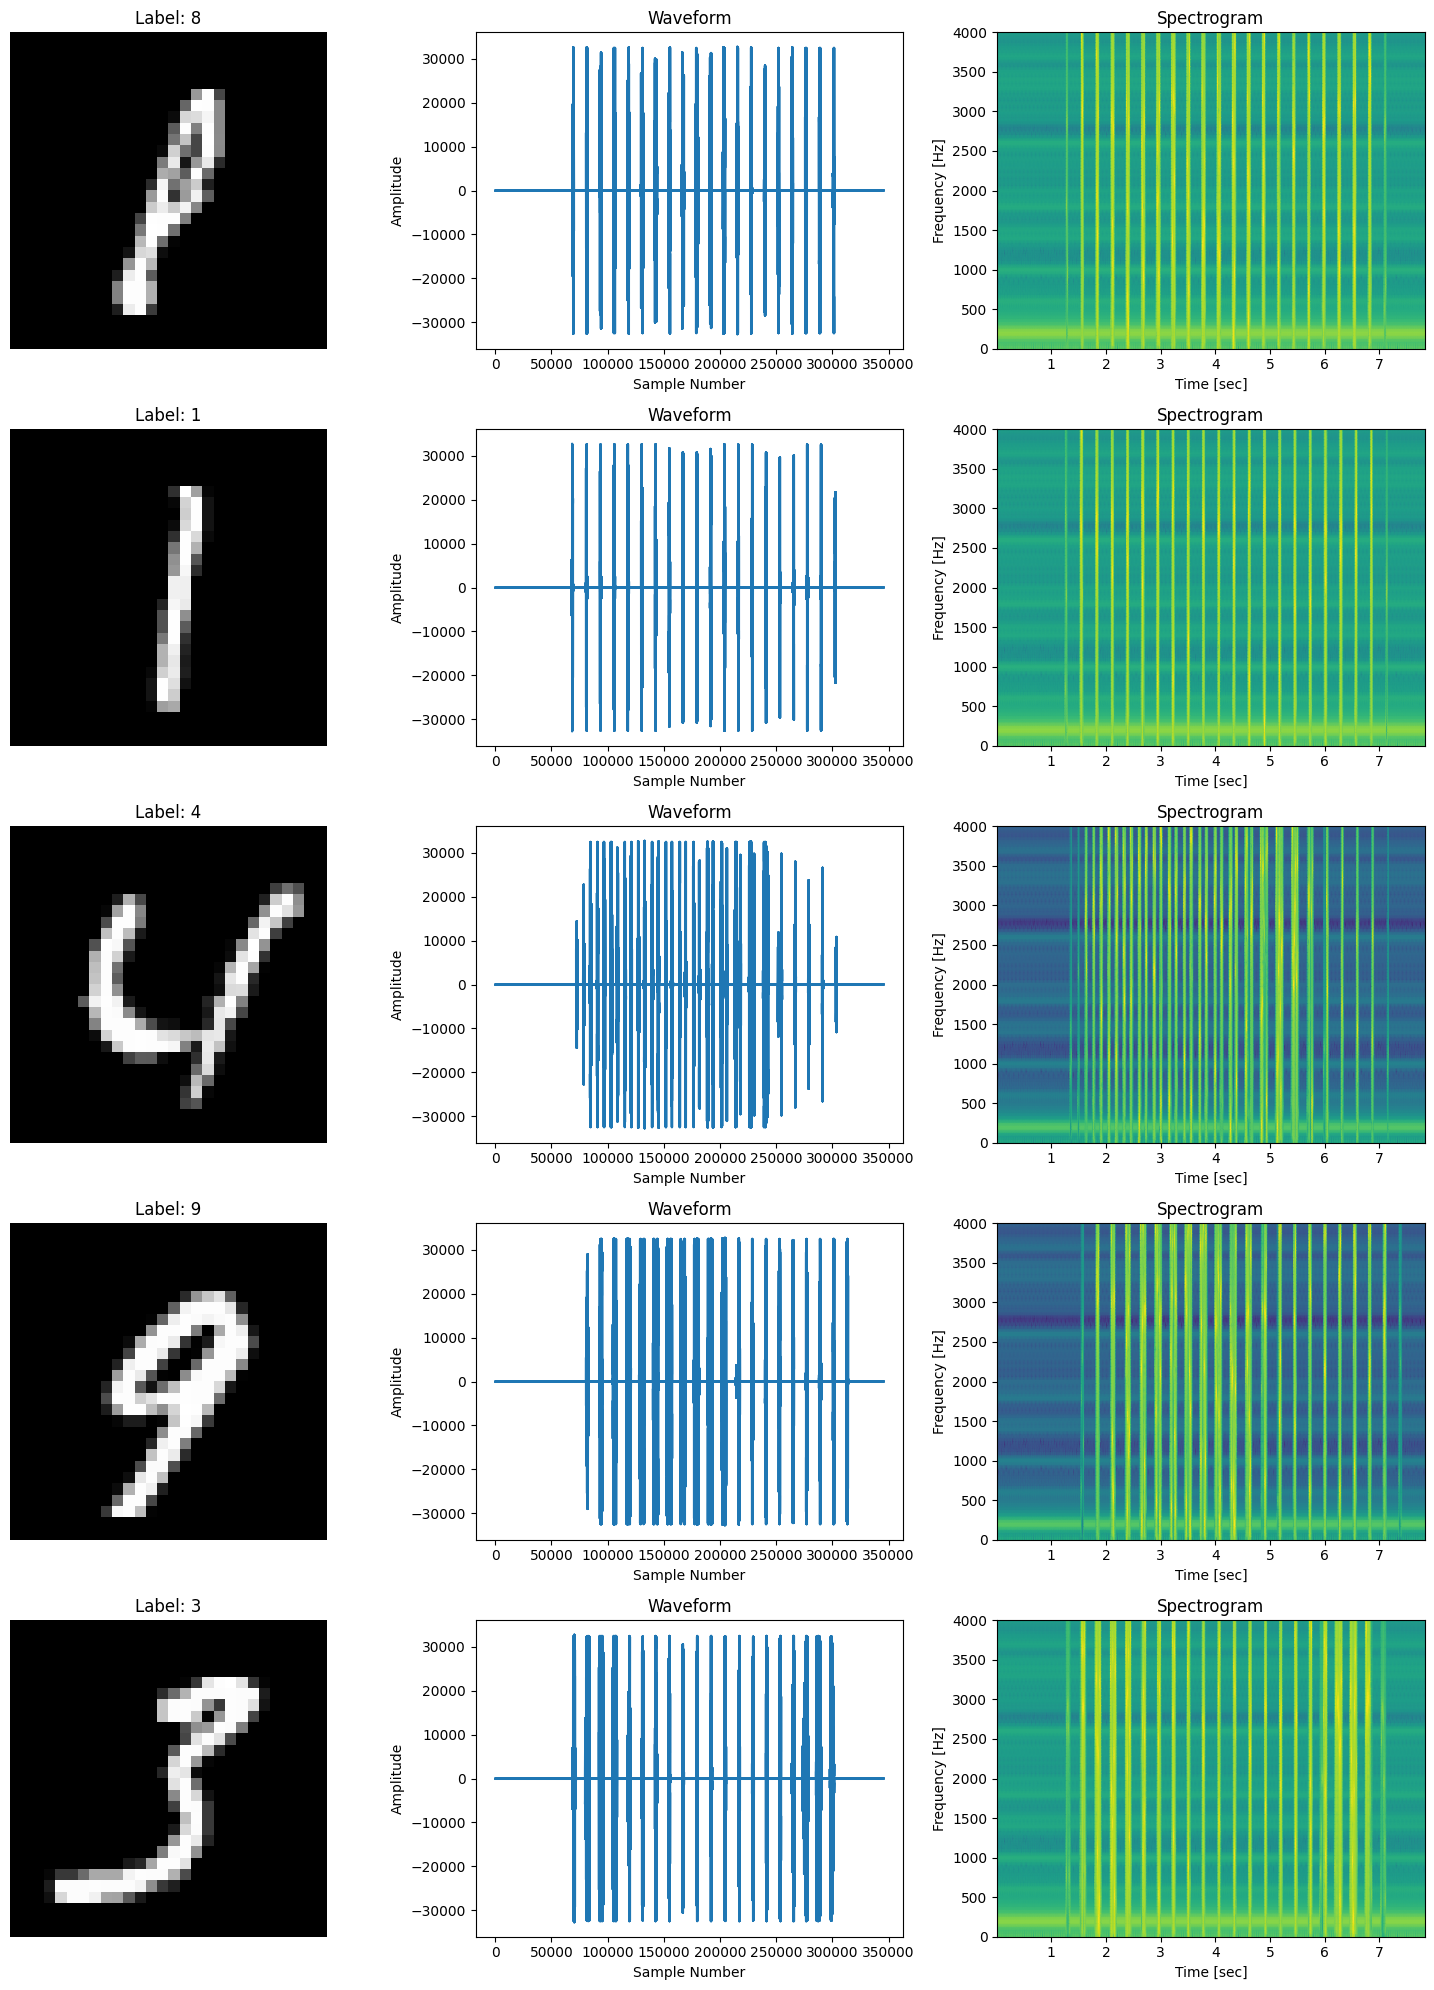

In [24]:
# Plot sample images and their audio features
fig, axs = plt.subplots(5, 3, figsize=(15, 20))  # 5 rows, 3 columns
sample_indices = np.random.choice(len(images), 5, replace=False)  # Choose 5 random indices

for plot_index, data_index in enumerate(sample_indices):
    image = images.to_numpy()[data_index].reshape(28, 28).astype(int)
    label = labels[data_index]
    audio = synthesize_sound(image)

    # Plot image
    axs[plot_index, 0].imshow(image, cmap='gray')
    axs[plot_index, 0].set_title(f'Label: {label}')
    axs[plot_index, 0].axis('off')
    
    # Plot waveform
    axs[plot_index, 1].plot(audio)
    axs[plot_index, 1].set_title('Waveform')
    axs[plot_index, 1].set_xlabel('Sample Number')
    axs[plot_index, 1].set_ylabel('Amplitude')
    
    # Plot spectrogram
    frequencies, times, Sxx = spectrogram(audio, fs=44100, window='hann', nperseg=1024, noverlap=512, nfft=1024)
    axs[plot_index, 2].pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    axs[plot_index, 2].set_title('Spectrogram')
    axs[plot_index, 2].set_xlabel('Time [sec]')
    axs[plot_index, 2].set_ylabel('Frequency [Hz]')
    axs[plot_index, 2].set_ylim(0, 4000)

plt.tight_layout()
plt.show()


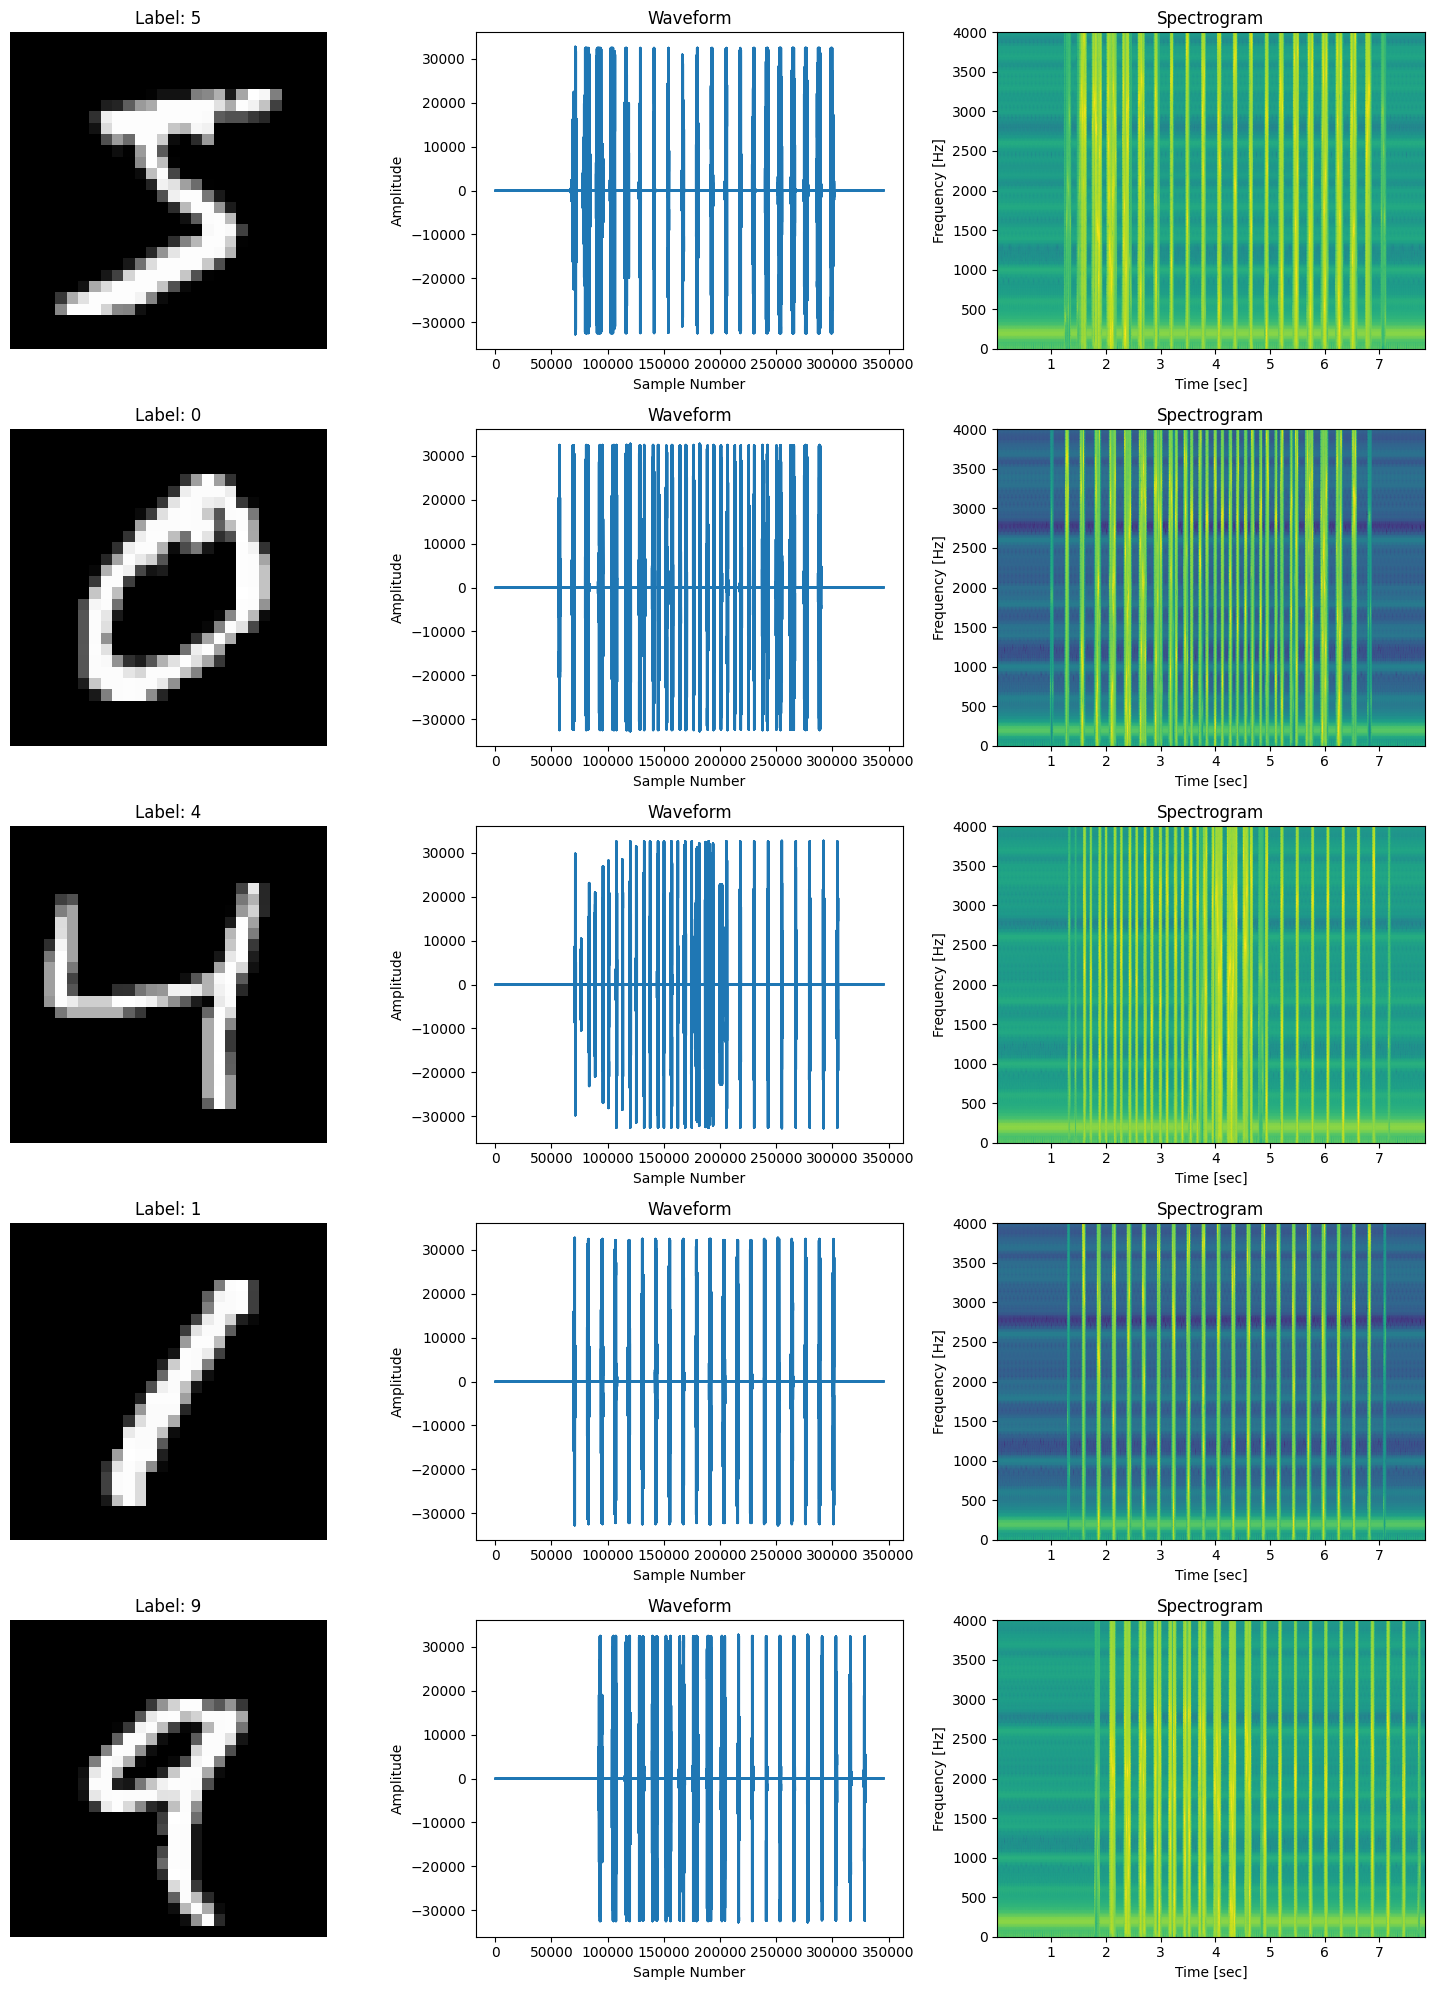

In [21]:
import os
import numpy as np
from sklearn.datasets import fetch_openml
from scipy.io.wavfile import write
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Load MNIST data
mnist = fetch_openml('mnist_784', version=1)
images, labels = mnist["data"], mnist["target"]

# Create directories for outputs
os.makedirs("audio_files", exist_ok=True)
os.makedirs("image_files", exist_ok=True)

def extract_features(image):
    """Extract normalized intensity and edge strength from an image."""
    normalized_intensity = image / 255.0
    gradient = np.gradient(normalized_intensity)
    edge_strength = np.sqrt(gradient[0]**2 + gradient[1]**2)
    return normalized_intensity, edge_strength

def map_features_to_sound_params(intensity, edges, max_frequency=4000, max_volume=32767):
    """Map intensity and edges to sound parameters."""
    frequencies = np.interp(edges, [edges.min(), edges.max()], [200, max_frequency])
    volumes = np.interp(intensity, [intensity.min(), intensity.max()], [100, max_volume])
    return frequencies, volumes

def synthesize_sound(image, sample_rate=44100, duration_per_pixel=0.01, max_volume=32767):
    """Synthesize sound from an image based on intensity and edges."""
    pixel_intensity, edges = extract_features(image)
    frequencies, volumes = map_features_to_sound_params(pixel_intensity, edges)
    
    audio = np.zeros(int(sample_rate * duration_per_pixel * image.shape[0] * image.shape[1]))
    t = np.linspace(0, duration_per_pixel, int(sample_rate * duration_per_pixel), False)
    
    index = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            freq = frequencies[i, j]
            vol = volumes[i, j]
            waveform = vol * np.sin(2 * np.pi * freq * t)
            audio[index:index+len(t)] += waveform
            index += len(t)
    
    audio = audio / np.max(np.abs(audio)) * max_volume
    return audio.astype(np.int16)

# Process each image, save audio and images, and prepare for plotting a few examples
fig, axs = plt.subplots(5, 3, figsize=(15, 20))
for index in range(5):  # Change this range to process more images
    image = images.to_numpy()[index].reshape(28, 28).astype(int)
    label = labels[index]
    audio = synthesize_sound(image)
    
    # Save audio file
    audio_filename = f"audio_files/mnist_digit_{label}_{index}.wav"
    write(audio_filename, 44100, audio)
    
    # Save image file
    plt.imsave(f"image_files/mnist_digit_{label}_{index}.png", image, cmap='gray')
    
    # Plot image
    axs[index, 0].imshow(image, cmap='gray')
    axs[index, 0].set_title(f'Label: {label}')
    axs[index, 0].axis('off')
    
    # Plot waveform
    axs[index, 1].plot(audio)
    axs[index, 1].set_title('Waveform')
    axs[index, 1].set_xlabel('Sample Number')
    axs[index, 1].set_ylabel('Amplitude')
    
    # Plot spectrogram
    frequencies, times, Sxx = spectrogram(audio, fs=44100, window='hann', nperseg=1024, noverlap=512, nfft=1024)
    axs[index, 2].pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    axs[index, 2].set_title('Spectrogram')
    axs[index, 2].set_xlabel('Time [sec]')
    axs[index, 2].set_ylabel('Frequency [Hz]')
    axs[index, 2].set_ylim(0, 4000)

plt.tight_layout()
plt.show()
